In [9]:
from __future__ import annotations
import pathlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure
import PIL.Image
import tqdm
import torch
from pytorch_msssim import ms_ssim

import utils

In [2]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [3]:
recording = "sun11"
vid_path = pathlib.Path(f"../data/infer/{recording}") / f"vid.mp4"
rec_path = pathlib.Path(f"../data/test-res/466/{recording}") / "reconstructed.mp4"
frames = utils.read_video(vid_path)
rec_frames = utils.read_video(rec_path)
frames.array = utils.crop_vid_to_size(frames.array, 640, 480)

Reading ..\data\infer\sun11\vid.mp4: 100%|██████████| 1531/1531 [00:00<00:00, 2304.03it/s]
Reading ..\data\test-res\466\sun11\reconstructed.mp4: 100%|██████████| 1531/1531 [00:00<00:00, 2266.71it/s]


In [4]:
frames_gs = np.array(
    [
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        for frame in tqdm.tqdm(frames.array, desc="Converting frames to grayscale")
    ]
)
rec_frames_gs = np.array(
    [
        cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        for frame in tqdm.tqdm(
            rec_frames.array, desc="Converting reconstructed frames to grayscale"
        )
    ]
)

Converting reconstructed frames to grayscale: 100%|██████████| 1531/1531 [00:00<00:00, 9345.05it/s]


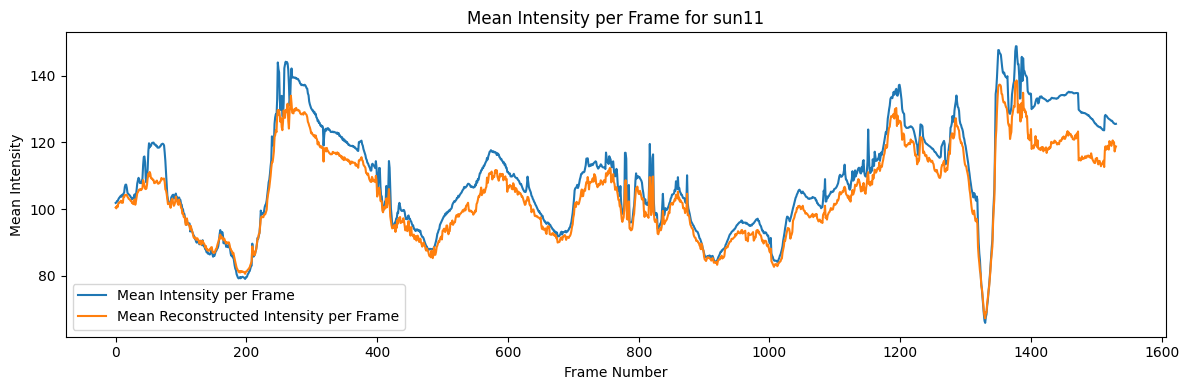

In [5]:
mean_intensity_per_frame = frames_gs.mean(axis=(1, 2))
mean_rec_intensity_per_frame = rec_frames_gs.mean(axis=(1, 2))

plt.figure(figsize=(12, 4))
plt.plot(mean_intensity_per_frame, label="Mean Intensity per Frame")
plt.plot(mean_rec_intensity_per_frame, label="Mean Reconstructed Intensity per Frame")
plt.xlabel("Frame Number")
plt.ylabel("Mean Intensity")
plt.title(f"Mean Intensity per Frame for {recording}")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
mean_intensity_per_frame

array([101.8198763 , 101.95701823, 102.35638672, ..., 125.53882487,
       125.49201497, 125.54151367])

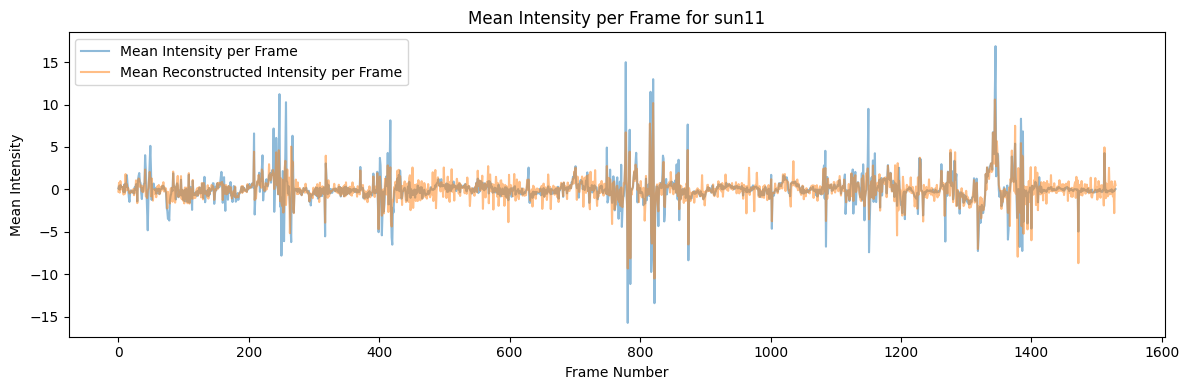

In [7]:
change_in_mean_intensity = np.diff(mean_intensity_per_frame)
change_in_mean_rec_intensity = np.diff(mean_rec_intensity_per_frame)
plt.figure(figsize=(12, 4))
plt.plot(change_in_mean_intensity, label="Mean Intensity per Frame", alpha=0.5)
plt.plot(
    change_in_mean_rec_intensity,
    label="Mean Reconstructed Intensity per Frame",
    alpha=0.5,
)
plt.xlabel("Frame Number")
plt.ylabel("Mean Intensity")
plt.title(f"Mean Intensity per Frame for {recording}")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
np.std(change_in_mean_intensity), np.std(change_in_mean_rec_intensity)

(1.8568833251802483, 1.4727806303850999)

In [ ]:
tssim_orig = []
tssim_rec = []
for prev, curr in tqdm.tqdm(
    zip(frames.array[:-1], frames.array[1:]), total=frames.array.shape[0] - 1
):
    prev_torch = torch.from_numpy(prev.transpose(2, 0, 1) / 255.0).unsqueeze(0)
    curr_torch = torch.from_numpy(curr.transpose(2, 0, 1) / 255.0).unsqueeze(0)
    tssim_orig.append(ms_ssim(prev_torch, curr_torch, data_range=1.0))

for prev, curr in tqdm.tqdm(
    zip(rec_frames.array[:-1], rec_frames.array[1:]),
    total=rec_frames.array.shape[0] - 1,
):
    prev_torch = torch.from_numpy(prev.transpose(2, 0, 1) / 255.0).unsqueeze(0)
    curr_torch = torch.from_numpy(curr.transpose(2, 0, 1) / 255.0).unsqueeze(0)
    tssim_rec.append(ms_ssim(prev_torch, curr_torch, data_range=1.0))

tssim_orig = np.array(tssim_orig)
tssim_rec = np.array(tssim_rec)

100%|██████████| 1530/1530 [02:24<00:00, 10.57it/s]


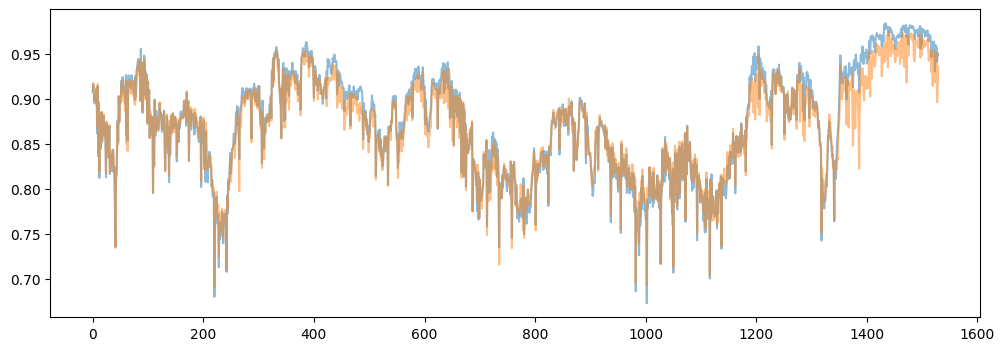

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(tssim_orig, label="Mean Block Frame", alpha=0.5)
plt.plot(tssim_rec, label="Mean Reconstructed Block Frame", alpha=0.5)

In [56]:
orig_pixelwise_diff = np.diff(frames_gs, axis=0)
rec_pixelwise_diff = np.diff(rec_frames_gs, axis=0)

In [57]:
mean_block_frame = skimage.measure.block_reduce(
    orig_pixelwise_diff, block_size=(1, 48, 48), func=np.mean
)
mean_block_frame = np.median(mean_block_frame, axis=(1, 2))
mean_rec_block_frame = skimage.measure.block_reduce(
    rec_pixelwise_diff, block_size=(1, 48, 48), func=np.mean
)
mean_rec_block_frame = np.median(mean_rec_block_frame, axis=(1, 2))

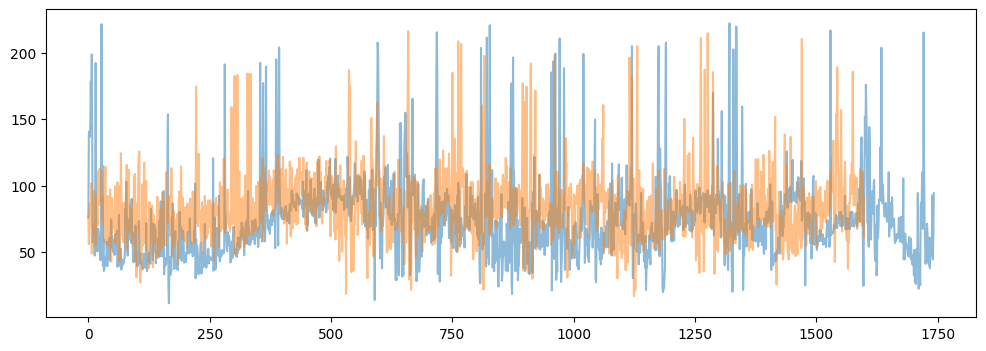

In [58]:
plt.figure(figsize=(12, 4))
plt.plot(mean_block_frame, label="Mean Block Frame", alpha=0.5)
plt.plot(mean_rec_block_frame, label="Mean Reconstructed Block Frame", alpha=0.5)